In [1]:
# imports
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import keras as K
import numpy as np
import pandas as pd
import os
import glob
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator


In [2]:
# get directories
main_direc = os.getcwd()
images_dir = os.path.join(main_direc, 'data/images/images')

# csv location
artist_csv_loc = os.path.join(main_direc, 'data/artists.csv')

## Loading Data
The below section loads in the data, making necessary preprocess changes.
Generators are used to augment the data.

### Hyperparameter Section for data preprocessing
The following code block allows you to set different hyperparams for loading in
the images.

In [16]:
"""
Set hyperparams for the number of classes and image generators
"""

IMG_WIDTH = 299
IMG_HEIGHT = 299
BATCH_SIZE = 64
NUM_ARTISTS = 10 # this is 11 to get to 10 classes, can be changed...

### DataFrame management
The following code block loads the artists csv into pandas dataframe, sorts by
number of paintings, and makes a dataframe with the top 10 artists by painting
count, to give us the most amount of data possible.

In [15]:
# Collecting Needed Images
artists = pd.read_csv(artist_csv_loc)

# Creating a dataframe with the top 10 artists by number of paintings
artists_sort = artists.sort_values(by=['paintings'], ascending=False)

# add one to reach the first 10 classes
artists_top = artists_sort.head(NUM_ARTISTS + 1)
print(artists_top)

# Images
artists_dir = os.listdir(images_dir) # Files are named after each artists

# Images DataFrame
artists_top_name = artists_top['name'].str.replace(' ', '_').values

images_df = pd.DataFrame()
for name in artists_top_name:
    images_df = pd.concat([images_df, pd.DataFrame(data={'Path': glob.glob('data/images/images/' + name + '/*'), 'Name': name})], ignore_index=True)

print(images_df)

train_df = images_df.sample(frac=0.8, random_state=200)
test_df = images_df.drop(train_df.index)

if K.backend.image_data_format() == 'channels_first':
    input_shape = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

    id                   name        years                         genre  \
8    8       Vincent van Gogh  1853 – 1890            Post-Impressionism   
30  30            Edgar Degas  1834 - 1917                 Impressionism   
13  13          Pablo Picasso  1881 - 1973                        Cubism   
15  15  Pierre-Auguste Renoir  1841 - 1919                 Impressionism   
19  19         Albrecht Dürer  1471 - 1528          Northern Renaissance   
46  46           Paul Gauguin  1848 – 1903  Symbolism,Post-Impressionism   
16  16         Francisco Goya  1746 - 1828                   Romanticism   
31  31              Rembrandt  1606 - 1669                       Baroque   
20  20          Alfred Sisley  1839 - 1899                 Impressionism   
32  32                 Titian  1488 - 1576    High Renaissance,Mannerism   
22  22           Marc Chagall  1887 - 1985                   Primitivism   

                 nationality  \
8                      Dutch   
30                    F

### Building generators
The next code block builds generators for augmenting the data.

In [20]:
"""
Build generators
"""

train_generator = ImageDataGenerator(rescale=1.0 / 255,
                                    rotation_range=20,
                                    zoom_range=0.05,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    shear_range=0.05,
                                    horizontal_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.15,
                                    preprocessing_function=preprocess_input
                                    )

test_generator = ImageDataGenerator(rescale=1.0 / 255, preprocessing_function=preprocess_input)

train_gen = train_generator.flow_from_dataframe(
    train_df,
    shuffle=True,
    x_col='Path',
    y_col='Name',
    class_mode='categorical',
    subset="training",
    batch_size=BATCH_SIZE,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    seed=42
)

valid_gen = train_generator.flow_from_dataframe(
    train_df,
    subset="validation",
    shuffle=True,
    x_col='Path',
    y_col='Name',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    seed=42
)

test_gen = test_generator.flow_from_dataframe(
    test_df,
    x_col='Path',
    batch_size=1,
    shuffle=False,
    class_mode=None,
    target_size=(IMG_WIDTH, IMG_HEIGHT)
)

# Set the amount of steps for training, validation, and testing data
# based on the batch size
steps_train = train_gen.n//train_gen.batch_size
steps_valid = valid_gen.n//valid_gen.batch_size
steps_test = test_gen.n//test_gen.batch_size

Found 2328 validated image filenames belonging to 10 classes.
Found 410 validated image filenames belonging to 10 classes.
Found 684 validated image filenames.


## BASELINE MODEL
The following model is a very simple convolutional neural network. It is not
very accurate.

In [6]:
# number of epochs for the baseline model
n_epochs = 3

sequential_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(NUM_ARTISTS - 1)
])

# compile model
sequential_model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)


2021-12-13 15:52:54.535554: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# fit model
# FITTING THE MODEL
# create a checkpoint for the model
# TODO: change name of model
checkpt = ModelCheckpoint(filepath='baseline_model.hdf5', save_best_only=True, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Fit the model
sequential_model.fit_generator(
    generator = train_gen,
    steps_per_epoch=steps_train,
    validation_data = valid_gen,
    validation_steps = steps_valid,
    verbose=1,
    epochs=1,
    callbacks=[checkpt, early_stop]
)

/usr/local/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-12-13 15:53:00.916270: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


33/33 [==============================] - 123s 4s/step - loss: 2.1504 - accuracy: 0.2213 - val_loss: 2.1276 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 2.12758, saving model to baseline_model.hdf5


### Metrics for baseline model
The following code blocks create plots for the baseline model.

In [38]:
labels = test_gen.class_indices
print(list(labels.values()))

AttributeError: 'DataFrameIterator' object has no attribute 'class_indices'

In [33]:
# Load model weights
# TODO: change name of model
sequential_model.load_weights('baseline_model.hdf5')

test_gen.reset()
y_pred = sequential_model.predict(test_gen, steps=steps_test, verbose=1)

predicted_class_indices=np.argmax(y_pred,axis=1)

labels = (train_gen.class_indices)
labels = list(labels.values())

# print(labels)
# filenames=(test_gen.filenames)
# results=pd.DataFrame({"label":filenames,
#                       "Predictions":y_pred})
# results.to_csv("results.csv",index=False)

con_mat = tf.math.confusion_matrix(labels=labels, predictions=y_pred).numpy()

#labels = dict((v,k) for k,v in labels.items())
#predictions = [labels[k] for k in predicted_class_indices]

# confusion matrix


#print(test_gen.get_classes(test_gen,))

#con_mat = tf.math.confusion_matrix(labels=labels, predictions=y_pred).numpy()

637/637 [==============================] - 17s 27ms/step
[[-1.2984949e-01 -3.0789223e-01  7.6957518e-01 ...  6.1712111e-05
  -2.0180282e-01 -1.9270594e-01]
 [-1.2984657e-01 -3.0788100e-01  7.6954705e-01 ...  6.3120271e-05
  -2.0179576e-01 -1.9269826e-01]
 [-1.2985814e-01 -3.0790660e-01  7.6961011e-01 ...  6.2887440e-05
  -2.0181060e-01 -1.9271283e-01]
 ...
 [-1.2985493e-01 -3.0790982e-01  7.6962328e-01 ...  6.2041800e-05
  -2.0181763e-01 -1.9271894e-01]
 [-1.2983635e-01 -3.0786046e-01  7.6949191e-01 ...  6.2885578e-05
  -2.0178154e-01 -1.9268306e-01]
 [-1.2985118e-01 -3.0789199e-01  7.6957339e-01 ...  6.2766369e-05
  -2.0180121e-01 -1.9270451e-01]]


InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [9] != values[1].shape = [637,9] [Op:Pack] name: stack

## Clay's Model
The following model was designed by Clay Kaufmann. It uses Inception V3 as a
base line, and makes modifications from there.

### Hyperparameter Block
Set different hyperparameters for the model with the following block.

In [21]:
"""
Hyperparameters here:
"""

N_EPOCHS = 10
LEARNING_RATE = 0.001 # 0.001 is the default for Adam set by TensorFlow
OPTIMIZER = tf.optimizers.Adam(learning_rate=LEARNING_RATE)
LOSS_FUNCTION = tf.losses.CategoricalCrossentropy(from_logits=False)

In [22]:
"""
Build the model
"""

# set the input for VGG
inp = Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))

# load model
base_model = InceptionV3(include_top=False, input_tensor=inp, pooling='max', weights='imagenet')

# set base model to not be trainable
base_model.trainable = False

# create sequential model
final_model = tf.keras.Sequential()

# add the base model in
final_model.add(base_model)

final_model.add(K.layers.Flatten())
final_model.add(K.layers.BatchNormalization())
final_model.add(Dense(256, activation='relu'))
final_model.add(K.layers.Dropout(0.6))

# this needed to be the number of artists - 1
final_model.add(Dense(NUM_ARTISTS, activation='softmax'))

final_model.summary()

# compile model
final_model.compile(
  optimizer=OPTIMIZER,
  loss=LOSS_FUNCTION,
  metrics=['accuracy']
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_474 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total params: 22,338,090
Trainable params: 531,210
Non-trainable params: 21,806,880
____________________________________

In [8]:
"""
Train the model
"""

# create a checkpoint for the model
checkpt = ModelCheckpoint(filepath='clay_trained_model.hdf5', save_best_only=True, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Fit the model
final_model.fit_generator(
    generator = train_gen,
    steps_per_epoch=steps_train,
    validation_data = valid_gen,
    validation_steps = steps_valid,
    verbose=1,
    epochs=N_EPOCHS,
    callbacks=[checkpt, early_stop]
)

NameError: name 'final_model' is not defined

### Metrics Section
In the following codeblocks, metrics are used and plots are created to show how
the model performed.  
A confusion matrix is creating, using Seaborn's heatmap feature. A
classification report from sklearn metrics is also run.

In [35]:
"""
Make predictions
"""

# Load model weights
final_model.load_weights('clay_model_pre_fine_tune.hdf5')

# make predictions using the test set
predict = final_model.predict_generator(test_gen, steps=steps_test, verbose=1)

# collect the actual index of the predicted class
predicted_class = np.argmax(predict, axis=1)

/usr/local/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 27/637 [>.............................] - ETA: 49s

KeyboardInterrupt: 

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        64
           1       0.86      0.86      0.86        51
           2       0.71      0.83      0.77       121
           3       0.80      0.75      0.78        65
           4       0.67      0.91      0.77        97
           5       0.83      0.63      0.72        63
           6       0.75      0.70      0.72        76
           7       0.86      0.68      0.76        47
           8       0.93      0.51      0.66        53

    accuracy                           0.77       637
   macro avg       0.81      0.75      0.77       637
weighted avg       0.79      0.77      0.77       637



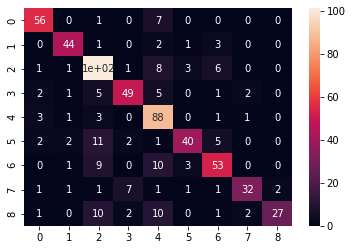

In [29]:
"""
Produce result metrics
"""

# collect the actual classes of the predictions
r = dict(train_gen.class_indices.items())
y_true = test_df['Name']
y_true = [r[k] for k in y_true]

# create confusion matrix
cm = confusion_matrix(y_true, predicted_class)
sns.heatmap(cm, annot=True)

# print classification report
print(classification_report(y_true, predicted_class))